# Sensitivities and factors of importance

This notebook shows the different methods for prioritizing input parameters:

- SRC indices
- Sobol' indices (by Monte Carlo and polynomial chaos post-processing)
- FAST methods (spectral methods) like Saltelli.

In [3]:
import numpy as np
import openturns as ot
from openturns.viewer import View
import pandas as pds
import pylab as pl
import pylab as plt
from sklearn.gaussian_process import GaussianProcess
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import r2_score
from sklearn.cross_validation import cross_val_score, LeaveOneOut
import warnings
warnings.filterwarnings('ignore')
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## 1. Loading Application Case Results

In [8]:
# Loading samples
fichier = "./Data/Resultats_Cas_Application.xlsx"

train = pds.read_excel(fichier, index_col=0) 

X_input, Y_input = train.values[:,:-1], train.values[:,-1:] 
Y_input = Y_input.reshape(Y_input.shape[0], 1)


# Distributions

lim = [[2, 12.2], [-0.5, 0.8], [-0.5, 0.8], [20, 90], [17,40]]

distribution = ot.ComposedDistribution([ot.Uniform(lim[0][0], lim[0][1]),
                                        ot.Uniform(lim[1][0], lim[1][1]),
                                        ot.Uniform(lim[2][0], lim[2][1]),
                                        ot.Uniform(lim[3][0], lim[3][1]),
                                        ot.Uniform(lim[4][0], lim[4][1])])
#Problem dimension
dim = distribution.getDimension()

## 2. Coefficients SRC

We assume that the studied **model** *g* is (approximately) **linear** in the input variables:

\begin{equation}
    Y = \beta_0 + \sum_{i=1}^n \beta_i X_i
\end{equation}

The **input variables** are also assumed to be **independent**. The variance can then be written:

\begin{equation}
    \text{Var}[Y] = \sum_{i=1}^n \beta_i^2 \text{Var}[X_i]
\end{equation}

The **SRC indices** (Standardized Regression Coefficient) are calculated as follows:

\begin{equation}
    SRC_i=\dfrac{ \beta_i^2 \, Var[X_i] }{Var[Y]}
\end{equation}

Each index is between 0 and 1 and the sum is equal to 1. The indices translate the portion of the variance of the response $Y$ that can be attributed to the variable $X_i$.

In [6]:
SRC = ot.CorrelationAnalysis_SRC(X_input, Y_input)

data = pds.DataFrame(dict(SRC=SRC*100), index=distribution.getDescription())
print (data.to_string(float_format='{:,.1f}'.format))

    SRC
X0 73.0
X1  9.2
X2  7.0
X3  3.3
X4 26.1


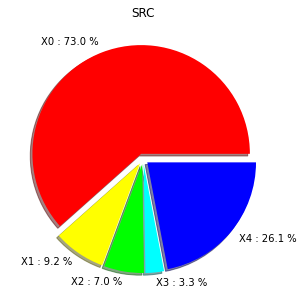

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
labels = [distribution.getDescription()[i] + ' : %0.1f %%' % (SRC[i]*100) for i in range(dim)]
View(ot.Pie(SRC), figure_kwargs={'figsize':(6,6)},
     pie_kwargs={'explode':[0.05]*dim, 'shadow':True, 'labels':labels}, axes=[ax])
ax.set_title('SRC')
fig.show()

# 3. Sobol indexes

The **variance of the output** $Y$ can be decomposed as follows :

\begin{equation}
    \text{Var}[Y] = \sum_{i=1}^n V_i + \sum_{1 \leq i < j \leq n} V_{i, j} + \ldots + V_{1, \dots, n}
\end{equation}

where the partial variance terms can be interpreted as successive conditional variances:

\begin{eqnarray}
    V_i & = & \text{Var}_{X_i} \left[\mathbb E[Y | X_i] \right] \\
    V_{i,j} & = & \text{Var}_{X_i, X_j} \left[\mathbb E[Y | X_i, X_j] \right] - V_i - V_j \\
     & \ldots &
\end{eqnarray}

The term $V_i$ corresponds to the **portion of variance** of the output explained by the single variable $X_i$. The term $V_{ij}$ corresponds to the part of the response variance explained by the interaction between $X_i$ and $X_j$.

#### Prime Indices
The **first order** sensitivity indices are defined by:
\begin{equation}
    S_i = \frac{V_i}{\text{Var}[Y]}
\end{equation}

#### Second-order indices
Sensitivity indices of order 2** are defined by:

\begin{equation}
    S_{ij} = \frac{V_{ij}}{\text{Var}[Y]}
\end{equation}

They express the sensitivity of $Y$ to the **interaction** of the variables $X_i$ and $X_j$ which
is not taken into account in the effect of the single variables.

It is thus possible to calculate the sensitivity indices associated with all the possible combinations of one, two, ..., $n$ variables. The sum is 1. The Sobol’ indices are interpreted as the part of the variance associated with each subset of input variables.

#### Total indices
To avoid calculating too many indices (of order 1, 2, etc.), we introduce the **total sensitivity indices** defined as the sum of all the indices relating to the variable $X_i$.

For example for $n = 3$: $S_{T_1} = S_1 + S_{12} + S_{13} + S_{123}$

Instead of calculating $2^n$ indices, we generally limit ourselves to those of order 1 and totals. A significant difference between the two indicates interactions between variables.

**The larger an index** (close to 1), **the more the variable contributes** significantly to the uncertainty of the model response.

## Polynomial Chaos

At the end of a polynomial chaos calculation, the global sensitivity analysis is obtained without additional cost. The partial variances $V_i$ are obtained as sum of squares of correctly sorted coefficients.

In the case of correlated input variables, the `ANCOVA` method can be used to quantify the effect of the correlation.

** Creation of the metamodel**

--------------------------
R2 chaos   = 0.8199842
--------------------------


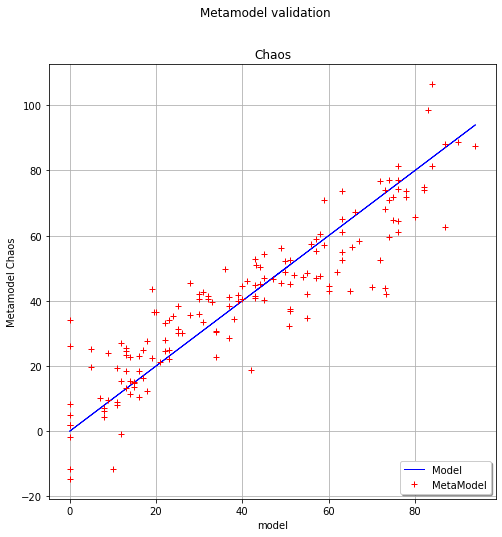

In [9]:
# Choice of the type of base polynomials
dim = distribution.getDimension()
polynome = ot.LegendreFactory()

# OpenTURNS has a class that allows to build the polynomials
# from the distribution using the Gram-Schmidt algorithm:
#StandardDistributionPolynomialFactory
polyCol = [0.]*dim
for i in range(dim):
    polyCol[i] = ot.StandardDistributionPolynomialFactory(distribution.getMarginal(i))
    
# Building the base
# By default the enumeration of polynomials is linear.
enumerateFunction = ot.EnumerateFunction(dim)
multivariateBasis = ot.OrthogonalProductPolynomialFactory(polyCol, enumerateFunction)
    
# Choice of the maximum degree of chaos
p = 2
indexMax = enumerateFunction.getStrataCumulatedCardinal(p)

# Choice of strategy for calculating the coefficients
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, indexMax)

#Regression method
regressionStrategy = ot.LeastSquaresStrategy()

# Creation of chaos

algochaos = ot.FunctionalChaosAlgorithm(X_input,
                                   Y_input,
                                   distribution,
                                   adaptiveStrategy,
                                   regressionStrategy)

# Launch of the calculation and recovery of the points of the design of experiments
algochaos.run()

algoMetamodel = [algochaos]
labels = ['Chaos', 'Kriging']

R2 = list()
fig = plt.figure(figsize=(8, 8))
ax = list()

for i, algo in enumerate(algoMetamodel):
    metaModelResult = algo.getResult()
    metaModel = metaModelResult.getMetaModel()

    # Coefficient of determination
    validation = ot.MetaModelValidation(X_input, Y_input, metaModel)
    R2.append(validation.computePredictivityFactor())
    
    ax.append(fig.add_subplot(1, 1, i+1))
    View(validation.drawValidation(), axes=[ax[i]])
    ax[i].set_ylabel('Metamodel ' + labels[i])
    ax[i].set_title(labels[i])

print ('--------------------------')
print ('R2 chaos   = %0.7f' % R2[0])
print ('--------------------------')

## Sobol Indices and Sensitivity

#### Construction

In [11]:
#Access to the random vector of chaos for the construction of Sobol indices
#PCE = ot.FunctionalChaosRandomVector(metaModelResult)
PCE = ot.FunctionalChaosSobolIndices(metaModelResult)
# #Sobol indexes :
#Order 1
S1_chaos = np.array([PCE.getSobolIndex([i]) for i in range(dim)])
#Order 2
S2_chaos = np.array([PCE.getSobolIndex([i, j]) for i in range(dim) for j in range(dim) if i < j])
#Order 3
ST_chaos = np.array([PCE.getSobolTotalIndex([i]) for i in range(dim)])

#### Plotting

Sobol indexes' (%):
    Ordre_1  Totaux
X0     60.8    21.8
X1      7.2    21.8
X2      2.9    21.8
X3      4.4    21.8
X4     15.5    21.8
Total interactions : 9.2

Sobol indices of order 2 (%):
X0 / X1  : 0.4
X0 / X2  : 0.4
X0 / X3  : 0.4
X0 / X4  : 0.4
X1 / X2  : 0.8
X1 / X3  : 0.8
X1 / X4  : 0.8
X2 / X3  : 0.1
X2 / X4  : 0.1
X3 / X4  : 7.4


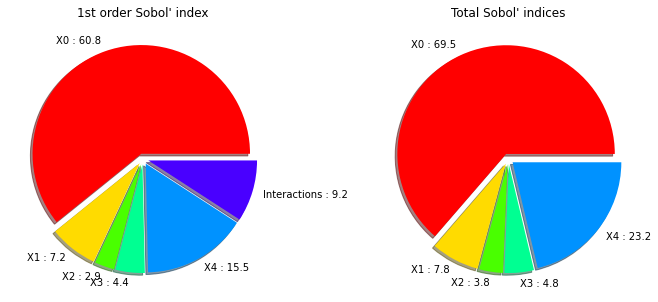

In [12]:
mean_data = np.mean(ST_chaos, axis=0)

# Calculation of interactions from 1st order indices
interaction_chaos = 1. - np.sum(S1_chaos)
if interaction_chaos < 0:
    interaction_chaos = 0

print ("Sobol indexes' (%):")
data = pds.DataFrame(dict(Ordre_1=S1_chaos*100, Totaux=mean_data*100), index=distribution.getDescription())
print (data.to_string(float_format='{:,.1f}'.format))
print ('Total interactions : %.1f' % (interaction_chaos*100))
print ('')
print ("Sobol indices of order 2 (%):")
for i in range(dim):
    for j in range(dim):
        if i < j:
            print (distribution.getDescription()[i], '/', distribution.getDescription()[j], \
                  ' : %0.1f' % (S2_chaos[i]*100))
                
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
labels = [distribution.getDescription()[i] + ' : %.1f' % (S1_chaos[i] * 100) for i in range(distribution.getDimension())]
labels.append('Interactions : %.1f' % (interaction_chaos * 100) )
View(ot.Pie(np.concatenate([S1_chaos, [interaction_chaos]])),
     pie_kwargs={'explode':[0.05]*(dim+1), 'shadow':True, 'labels':labels, 'colors':ot.Drawable().BuildDefaultPalette(6)},axes=[ax])
ax.set_title("1st order Sobol' index")

ax = fig.add_subplot(122)
labels = [distribution.getDescription()[i] + ' : %.1f' % (ST_chaos[i] * 100) for i in range(distribution.getDimension())]
View(ot.Pie(ST_chaos), pie_kwargs={'explode':[0.05]*dim, 'shadow':True, 'labels':labels,'colors':ot.Drawable().BuildDefaultPalette(6)}, axes=[ax])
ax.set_title("Total Sobol' indices")

#plt.savefig('Figures/Indices_Sobol_camembert')
fig.show()
